# Standard Analysis

This is the baseline approach to classifying the images. 

The sensitivity analysis conducted in the other notebooks will change individual steps in this analysis.

The techniques are described in the paper, so this notebook will focus more on implementation than explaning the approach.

## Module imports

We will use sklearn for the machine learning algorithms. Pandas provides a convenient way to organize

data and will help with plotting later. Matplotlib and seaborn are used to actually visualize the results.

In [1]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report


import skimage.io
from scipy.spatial.distance import cdist

import sys
sys.path.insert(0,'../')
from helper import classification_tools as ct
from helper import visualize as vis

%matplotlib inline

## Loading data
We already have the file paths, features, and labels from the last step, so we just need to retrieve it from disk

In [2]:
# fc1 features saved from the previous step
fc1_path = Path('..','data','features','VGG16_fc1_features_std.pickle')
assert fc1_path.is_file()

# label encoder model which converts string labels to integers.
le_path = Path('..','models','label_encoder.pickle')
assert le_path.is_file()

# load the data and label encoder into memory
with open(fc1_path, 'rb') as f:
    data = pickle.load(f)

with open(le_path, 'rb') as f:
    le = pickle.load(f)


In [3]:
files = data['filename']  # file paths to each image
fc1 = data['features']  # array containing fc1 features for each file
labels = data['labels']  # string labels for each image
y_gt = le.transform(labels)  # integer labels for each image

Now we have everything we need to do the analysis!

## Dimension reduction
### PCA
The first step in the analys is PCA, which will reduce the dimensionality of the data and hopefully filter out noise.

The question is- how many dimensions to keep?

There is no right answer, but we want to keep components that contain signal (ie significant variance) and get rid of ones

that are mostly noise. For high dimensional data, like our fc1 features, a rule of thumb is to select 50 components. Before blindly

selecting 50, we will see how much variance each component preserves.

In [4]:
pca_n = PCA(svd_solver='full')
x_pca_ = pca_n.fit_transform(fc1)

var_ = pca_n.explained_variance_ratio_.cumsum()

That was easy! Let's view the results.

variance preserved by 50 components: 0.736


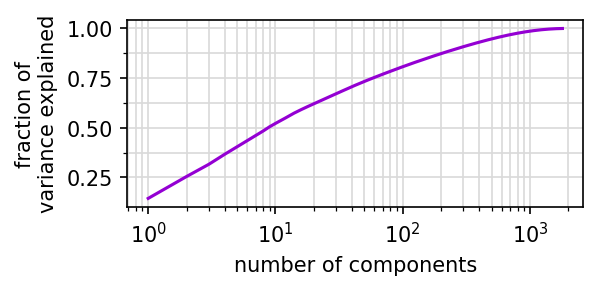

In [5]:
fig, ax = plt.subplots(figsize=(4,2),dpi=150,)
ax.grid('on', which='both', color=np.ones(3)*0.85)
ax.plot(range(1,len(var_)+1), var_, color='darkviolet')
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('fraction of\nvariance explained')

yt=np.linspace(1/4, 1, 4)
ytm = [np.mean([yt[i], yt[i+1]]) for i in range(len(yt)-1)]
ax.set_yticks(ytm, minor=True)


fig.tight_layout()
fig.savefig(Path('..','Figures','PCA_Var.png'), bbox_inches='tight')
print('variance preserved by 50 components: {:.3f}'.format(var_[50]))

50 components preserves  73.6% of the variance, so it seems to be a reasonable starting point for this task.

Let's proceed to extract 50 components. We will also look at a setting called whitening, which normalizes the variance

across each component after doing the decomposition. Think of this as weighting all of the components equally.

## T-SNE Visualization
T-SNE maps components in high-dimensional space to lower dimensions. It is commonly used to project data to 2d for visualization. 
This technique aims to preserve pairwise distances for points that are close to each other, and does not preserve distances for points that are far away from each other.

In [6]:
pca = PCA(n_components=50, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)

In [7]:
tsne = TSNE(n_components=2, random_state=12214)
tsne_w = TSNE(n_components=2, random_state=654753)
x_nw_tsne = tsne.fit_transform(x_nw)
x_w_tsne = tsne_w.fit_transform(x)

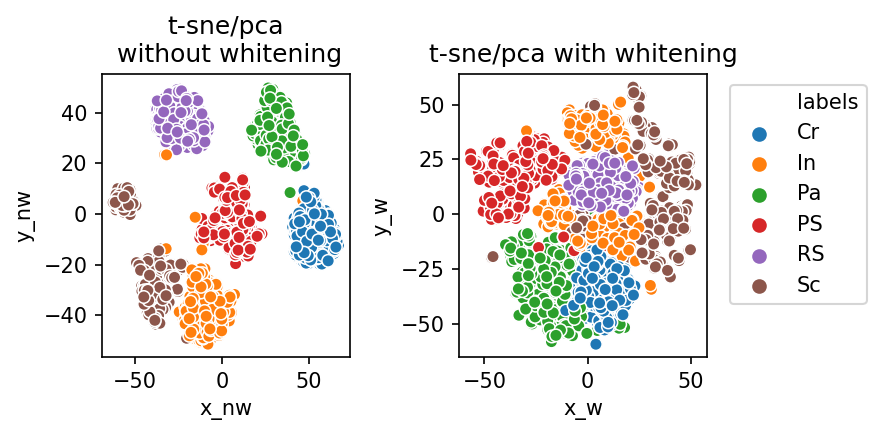

In [8]:
labels_ordered = le.inverse_transform(range(len(le.mapper)))
df = pd.DataFrame({'files': files,
                   'x_nw':x_nw_tsne[:,0],
                   'y_nw':x_nw_tsne[:,1],
                   'x_w': x_w_tsne[:,0],
                  'y_w': x_w_tsne[:,1],
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered,  ax=ax[0])
sns.scatterplot(data=df, x='x_w', y='y_w', hue='labels', hue_order=labels_ordered, ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('t-sne/pca\n without whitening')
ax[1].set_title('t-sne/pca with whitening')
fig.tight_layout()
plt.show()

The t-sne map without whitening shows much better clustering than the t-sne map with whitened components. However, as we will see, this turns out to be an artifact of t-sne, and

does not represent the actual clustering of the data in feature space. Whitening normalizes the variance, and therefore pairwise distances of points in feature space, so they do not

cluster in 2d as well. Despite this, we will see that they actually cluster better in feature space with whitening.

### We can also plot the images on the t-sne plot to see if we can gain any insights from the data

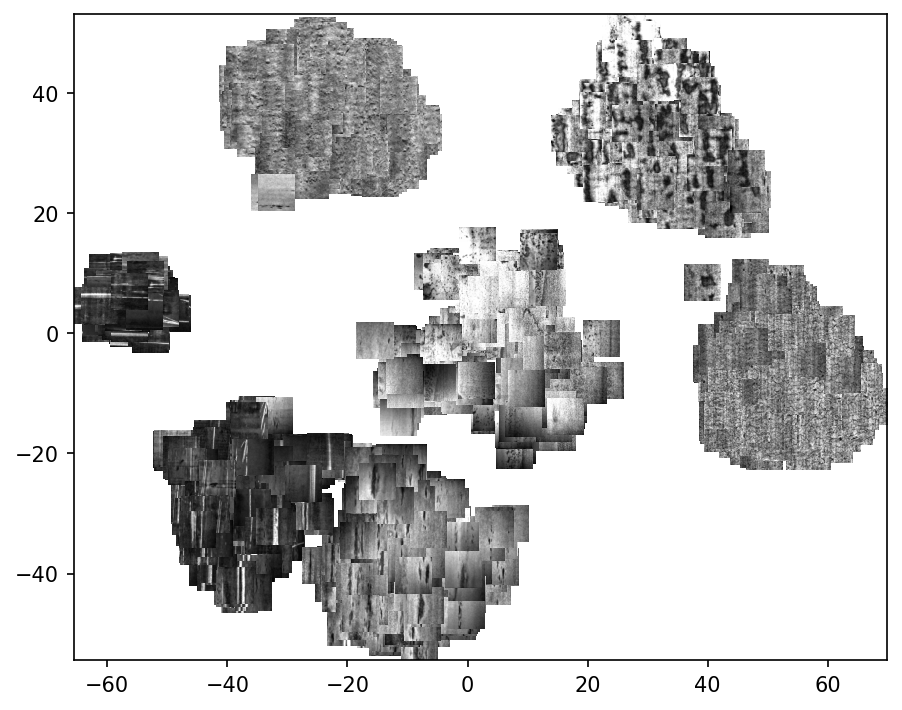

In [9]:
vis.pano_plot(x_nw_tsne[:,0], x_nw_tsne[:,1], files)

We can see how the clusters separate very well by defect class. Notice that for scratches there appear to be two different clusters.

This has to do with the orientation of the scratches- one for vertical, and the other for horizontal. 

The vertical scratches cluster is close to the inclusions, and we can see some visual similarity between these groups. However, the horizontal scratches appear in a separate, distinct cluster.

## Clustering
Now we can cluster the data with K-means. The process is very straightforward thanks to the tools provided in skimage.

The only trick is match the arbitrary cluster IDs returned from K-means to the ground truth labels they correspond to.

The method I used to do this is defined in helper.classification_tools, if you want to see the implementation.


In [10]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=2149673460)
kmeans.fit(x)
labels_unmatched = kmeans.labels_  # labels from k-means are arbitrary and must be mapped to the format of the ground truth labels
y_pred = ct.label_matcher(labels_unmatched, y_gt,)  # this function matches the labels so we can compare directly
print('inertia: {:.2f}'.format(kmeans.inertia_))


inertia: 80410.56


The inertia doesn't tell us much, but can be used to compare clustering results for multiple runs. 

This is the lowest value after 500 trials (from n_init=500).

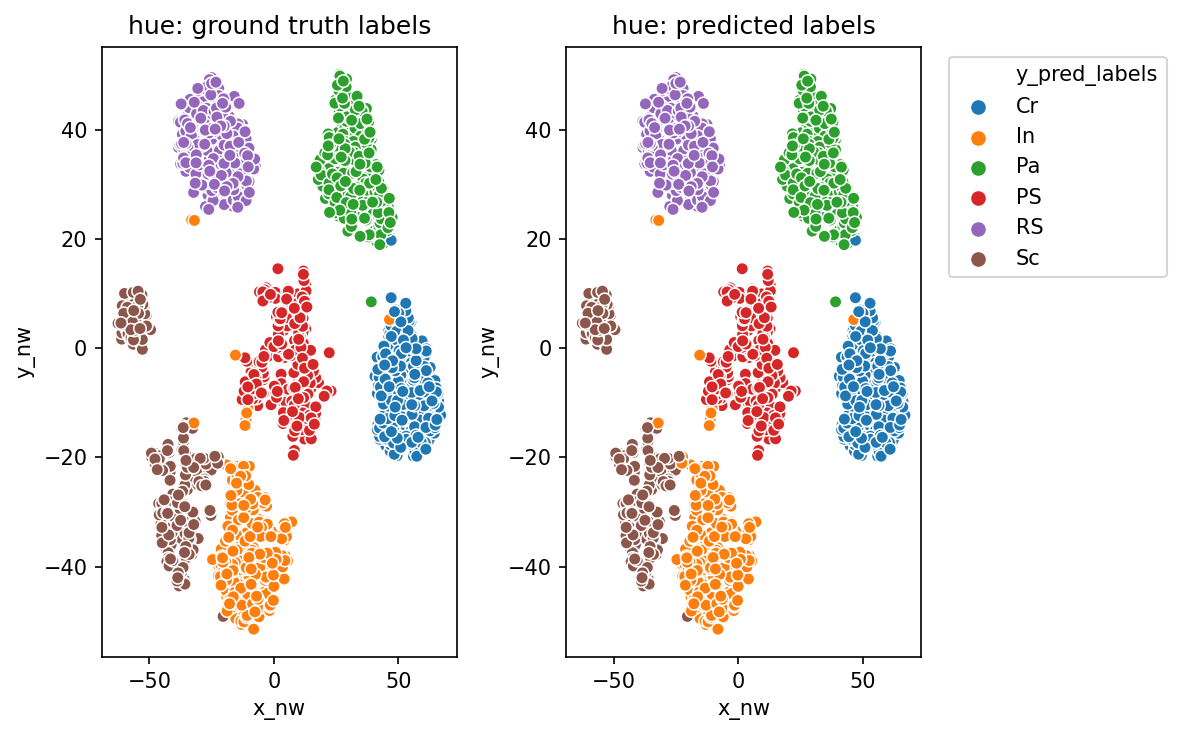

In [11]:
y_pred_str = le.inverse_transform(y_pred)
df['y_pred_labels'] = pd.Series(y_pred_str, index=files)

fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=150)


sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered, ax=ax[0]) # ground truth labels
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='y_pred_labels', hue_order=labels_ordered, ax=ax[1]) # predicted labels

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('hue: ground truth labels')
ax[1].set_title('hue: predicted labels')
fig.tight_layout()
plt.show()

The colors look identical, confirming we have very good clustering! They are almost exactly the same (ie we did not accidentally plot the same thing twice.) 

There are very slight differences around (-20,-20) with some of the scratches/inclusions being classified differently.

## Confusion matrix
This let's us visualize the classification performance with more detail.

In [12]:
%load_ext autoreload
%autoreload 2
from helper import visualize as vis

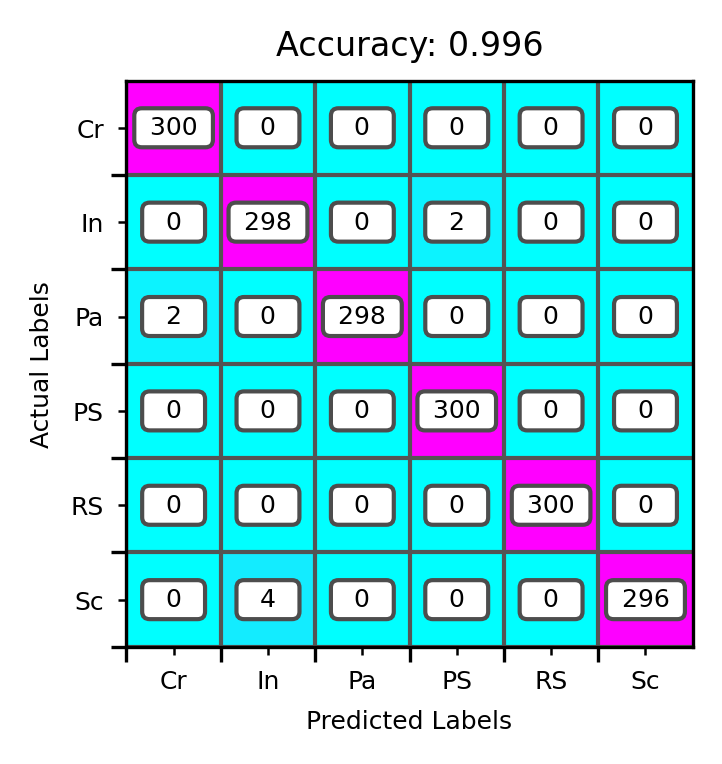

Accuracy: 0.996


In [13]:
# The confusion matrix allows us to evaluate the performance
CM = confusion_matrix(y_gt, y_pred)
vis.pretty_cm(CM, labels_ordered)
print('Accuracy: {:.3f}'.format(CM.trace()/CM.sum()))

99.6% accuracy, pretty good! But did we just get lucky with the random initialization of k-means, or is this process repeatable?

In [14]:
# This takes a couple minutes to run, be patient!
use_cache=True
std_10run_cache_path = Path('..','.neu_cache','st_10runresults.pickle')

if not use_cache or not std_10run_cache_path.is_file():
    rs = np.random.RandomState(seed=987654321)
    accuracies = np.zeros(10)
    for i, seed in enumerate(rs.randint(2**32, size=10)):
        kmeans_ = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=seed)
        kmeans_.fit(x)
        labels_unmatched_ = kmeans_.labels_
        y_pred_ = ct.label_matcher(labels_unmatched_, y_gt)
        acc = (y_pred_ == y_gt).sum()/len(y_gt)
        accuracies[i] = acc
    
    with open(std_10run_cache_path, 'wb') as f:
        pickle.dump({'accuracies':accuracies}, f)
else:
    with open(std_10run_cache_path, 'rb') as f:
        results_ = pickle.load(f)
        accuracies = results_['accuracies']

print(accuracies)

[0.99055556 0.995      0.99444444 0.995      0.99611111 0.99388889
 0.99166667 0.995      0.995      0.99333333]


In [15]:
print('10 runs:\n\tavg: {:.4f}\n\tstd: {:.4},\n\tmin: {:.4f}'.format(accuracies.mean(), np.std(accuracies), accuracies.min()))

10 runs:
	avg: 0.9940
	std: 0.001625,
	min: 0.9906


The approach achieves 99.4 $\pm$ 0.16% accuracy, and all trials achieve above 99% accuracy. Pretty good!

In [16]:
print(classification_report(y_gt, y_pred, target_names=labels_ordered, digits=3))

              precision    recall  f1-score   support

          Cr      0.993     1.000     0.997       300
          In      0.987     0.993     0.990       300
          Pa      1.000     0.993     0.997       300
          PS      0.993     1.000     0.997       300
          RS      1.000     1.000     1.000       300
          Sc      1.000     0.987     0.993       300

    accuracy                          0.996      1800
   macro avg      0.996     0.996     0.996      1800
weighted avg      0.996     0.996     0.996      1800



# Results without whitening
The t-sne projection showed much better clustering without whitening, yet we did clustering with whitening,
Whitening causes t-sne to not work as well, but it actually clusters the points better in the original feature space.
Here is what happens when we perform the same clustering approach on unwhitened pca components.

We will investigate the effects of PCA more in 06_pca_num_components_whiten_nowhiten.ipynb. However, to show why we are using whitening even though the t-sne maps don't look as good, here are the clustering results.

In [17]:
kmeans_nw = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=13)
kmeans_nw.fit(x_nw)
labels_unmatched_nw = kmeans_nw.labels_  # labels from k-means are arbitrary and must be mapped to the format of the ground truth labels
y_pred_nw = ct.label_matcher(labels_unmatched_nw, y_gt,)  # this function matches the labels so we can compare directly

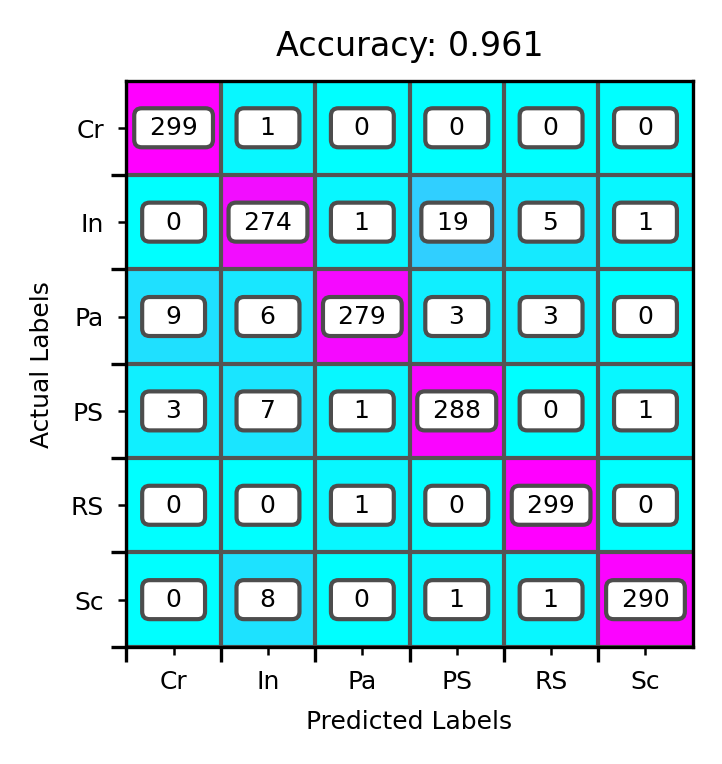

              precision    recall  f1-score   support

          Cr      0.961     0.997     0.979       300
          In      0.926     0.913     0.919       300
          Pa      0.989     0.930     0.959       300
          PS      0.926     0.960     0.943       300
          RS      0.971     0.997     0.984       300
          Sc      0.993     0.967     0.980       300

    accuracy                          0.961      1800
   macro avg      0.961     0.961     0.960      1800
weighted avg      0.961     0.961     0.960      1800



In [18]:
cm_nw = confusion_matrix(y_gt, y_pred_nw)
vis.pretty_cm(cm_nw, labelnames=labels_ordered)

print(classification_report(y_gt, y_pred_nw, target_names=labels_ordered, digits=3))

Clustering still achieves 96% accuracy, but not nearly as good. Whitening helps boost the signal in feature space. This isn't captured by t-sne because information is always lost when projecting down from 50 to 2 dimensions.

# Figures
At this point this part of the analysis is done, I just need to finish generating figures for the paper!

## t-sne figure illustrating 2 scratch clusters

In [19]:
# from the t-sne plot, the two Sc clusters can separate based on their y-value 
# y = -10 perfectly separates the clusters

Sc_label = le.transform(['Sc'])[0]
Scgroup1 = np.logical_and(x_nw_tsne[:,1] < -10, 
                          y_gt==Sc_label)
Scgroup2 = np.logical_and(x_nw_tsne[:,1] > -10, 
                          y_gt==Sc_label)

In [20]:
# to get the 'most typical' image from each cluster, we can select the
# point that is closest to the cluster centroid

x1_Sc1 = x_nw_tsne[Scgroup1]
x1_Sc2 = x_nw_tsne[Scgroup2]

i1 = cdist(x1_Sc1, 
        np.mean(x1_Sc1, axis=0)[np.newaxis, :]).argmin()
i2 = cdist(x1_Sc2, 
        np.mean(x1_Sc2, axis=0)[np.newaxis, :]).argmin()

In [21]:
labarray = np.asarray(labels)
filearray = np.asarray(files)

group1files = filearray[Scgroup1]
group2files = filearray[Scgroup2]

file1 = group1files[i1]
file2 = group2files[i2]

im1 = skimage.io.imread(file1)
im2 = skimage.io.imread(file2)

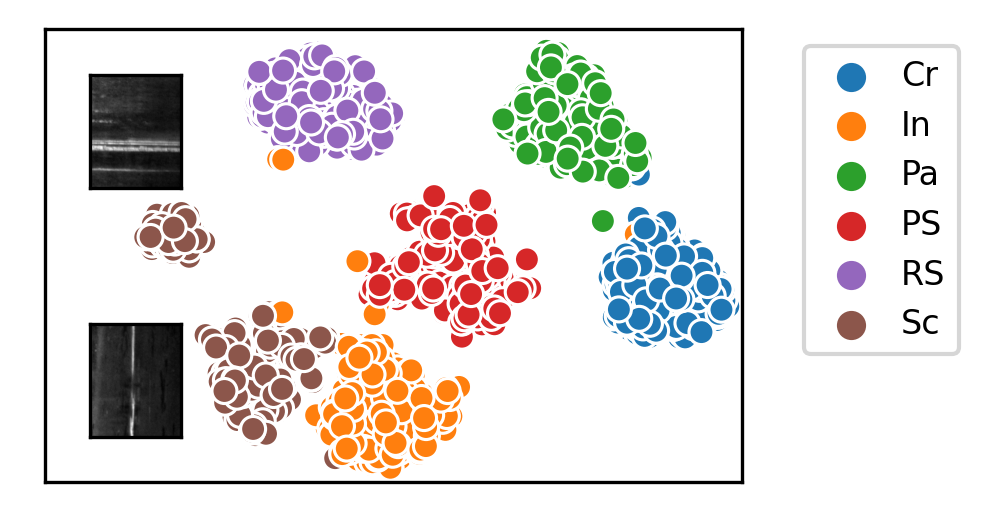

In [22]:
fig, ax  = plt.subplots(figsize=(3,2), dpi=300, facecolor='w')
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                 hue=labels, hue_order=le.labels_ordered, ax=ax)
ax.axis([-85,70,-55,55])
l1 = ax.legend(loc='upper center', ncol=1,
                bbox_to_anchor=(1.2,1), columnspacing=0.5, fontsize=(8), handletextpad=0.5)

ia1 = ax.inset_axes([0.005,0.1,0.25,0.25])
ia1.set_xticks([])
ia1.set_yticks([])
ia1.axis([0,1,0,1])
ia1.imshow(im1, cmap='gray', extent=(0,1,0,1))

ia2 = ax.inset_axes([0.005,0.65,0.25,0.25])
ia2.axis([0,1,0,1])
ia2.set_xticks([])
ia2.set_yticks([])
ia2.imshow(im2, extent=(0,1,0,1), cmap='gray')
# ax.plot(x1_Sc1[i1,0], x1_Sc1[i1,1], 'kd')
# ax.plot(x1_Sc2[i2,0], x1_Sc2[i2,1], 'ks')
ax.set_xticks([])
ax.set_yticks([])
#fig.tight_layout()

fig_path = Path('..','Figures')
fig.savefig(fig_path / 'tsne_scratches_inlay.png', bbox_inches='tight')

plt.show()

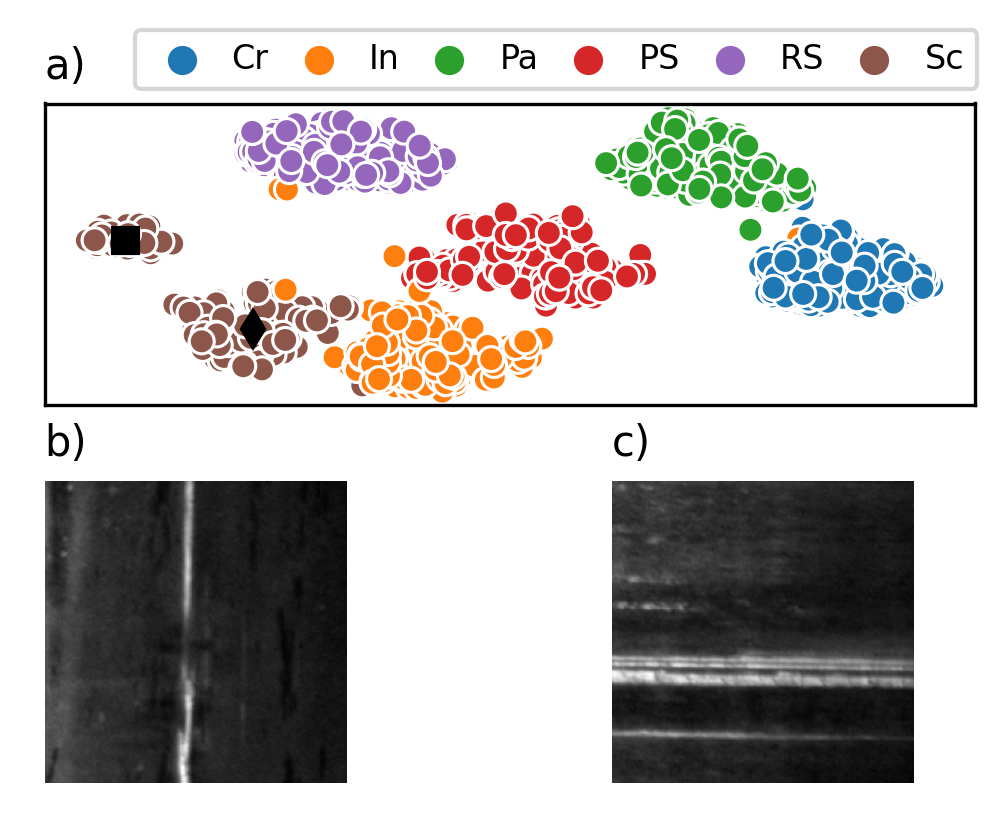

In [23]:
fig = plt.figure(figsize=(4,3), dpi=300)
gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.25)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                 hue=labels, hue_order=le.labels_ordered, ax=ax1)
l1 = ax1.legend(loc='upper center', ncol=6,
                bbox_to_anchor=(0.55,1.3), columnspacing=0.5, fontsize=(8), handletextpad=0.5)

ax1.plot(x1_Sc1[i1,0], x1_Sc1[i1,1], 'kd')
ax1.plot(x1_Sc2[i2,0], x1_Sc2[i2,1], 'ks')

ax1.set_xticks([])
ax1.set_yticks([])


ax2.imshow(im1, cmap='gray', extent=(0,1,0,1))
ax3.imshow(im2, cmap='gray', extent=(0,1,0,1))

bb = ax1.get_position()
ax2.set_position((0.125, *ax2.get_position().bounds[1:]))

ax2.axis('off')
ax3.axis('off')


ax1.set_title('a)', loc='left', fontsize=10)
ax2.set_title('b)', loc='left', fontsize=10)
ax3.set_title('c)', loc='left', fontsize=10)
#fig.tight_layout()
fig_path = Path('..','Figures')
fig.savefig(fig_path / 'tsne_scratches.png', bbox_inches='tight')

## t-SNE figure with labels colored by k-means labels from standard analysis

### Results determined using one of the trials from the 10 repeats

In [24]:
seed = 1844281023
kmeans_ = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=seed)
kmeans_.fit(x)
labels_unmatched_ = kmeans_.labels_
y_pred_ = ct.label_matcher(labels_unmatched_, y_gt)

In [25]:
strlabels = ct.label_matcher_multicluster(kmeans_.labels_, y_gt, le)

In [26]:
colors = np.concatenate((sns.color_palette()[:5], sns.color_palette()[5:6], sns.color_palette('bright')[5:6]), axis=0)

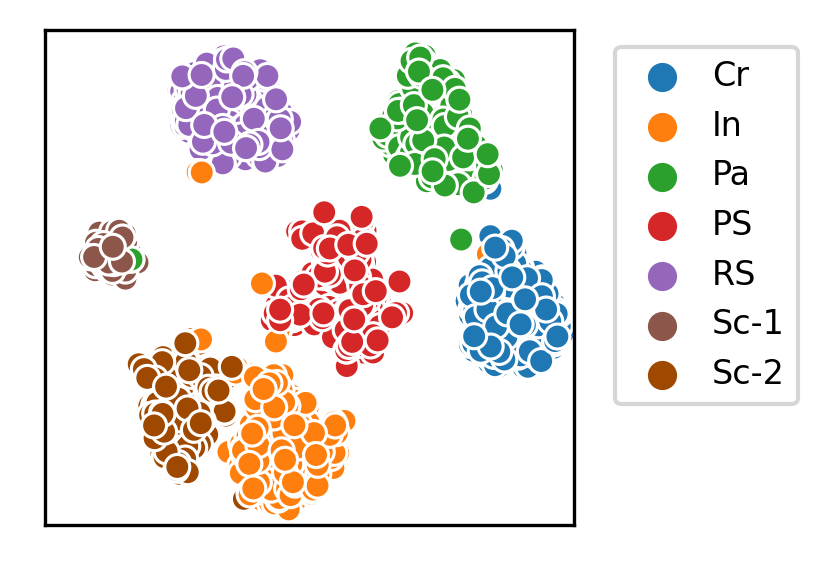

In [27]:
fig, ax  = plt.subplots(figsize=(3,2), dpi=300, facecolor='w')
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                 hue=strlabels, hue_order=sorted(np.unique(strlabels), key=lambda x: x.upper()), ax=ax, palette=list(colors))
ax.axis([-75,70,-55,55])
l1 = ax.legend(loc='upper center', ncol=1,
                bbox_to_anchor=(1.25,1), columnspacing=0.5, fontsize=(8), handletextpad=0.5)


# ax.plot(x1_Sc1[i1,0], x1_Sc1[i1,1], 'kd')
# ax.plot(x1_Sc2[i2,0], x1_Sc2[i2,1], 'ks')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

fig_path = Path('..','Figures')
fig.savefig(fig_path / 'tsne_kmeans_labels_std.png', bbox_inches='tight')

plt.show()

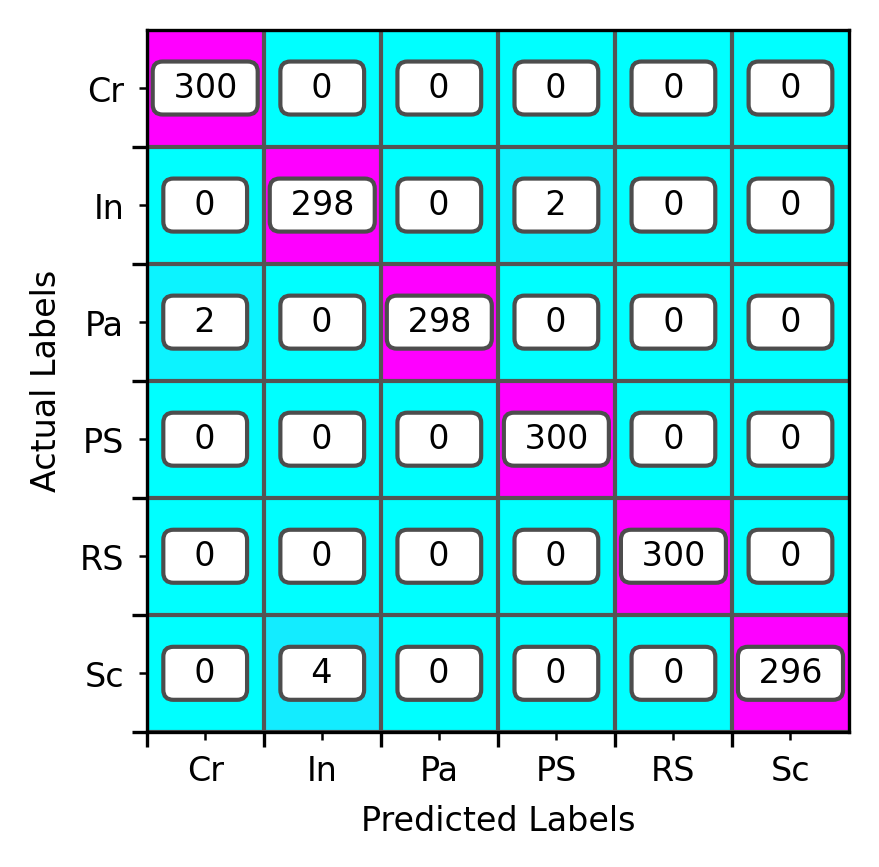

accuracy: 0.9955555555555555


In [28]:
intlabels = ct.label_matcher(kmeans.labels_, y_gt)

fig, ax = plt.subplots(figsize=(3,3), dpi=300)
CM = confusion_matrix(y_gt, intlabels)
vis.pretty_cm(CM, labelnames=le.labels_ordered, ax0=ax, fs=8, cmap='cool', )

fig.tight_layout()
fig.savefig(fig_path / 'CM_std.png', bbox_inches='tight')
plt.show()
print('accuracy: {}'.format(CM.trace()/CM.sum()))


In [29]:
print(ct.latex_report(y_gt, intlabels, le.labels_ordered))

\begin{tabular}{lcc}
	Class	& Precision	& Recall	\\  \hline 
	Cr	& 0.993 	& 1.000 	\\
	In	& 0.987 	& 0.993 	\\
	Pa	& 1.000 	& 0.993 	\\
	PS	& 0.993 	& 1.000 	\\
	RS	& 1.000 	& 1.000 	\\
	Sc	& 1.000 	& 0.987 	\\
\end{tabular}
